In [1]:
import numpy as np
import numpy.linalg as linalg
import matplotlib.pyplot as plt
import skimage
import skimage.io
import scipy.stats
from skimage.transform import resize
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from PIL import ImageTk, Image, ImageDraw
import PIL
from tkinter import *

First let's load in the digits as before

In [2]:
# Load in all digits
res = 28
digits = []
for i in range(10):
    digits.append([])
    I = skimage.io.imread("Digits/{}.png".format(i))/255.0
    row = 0
    col = 0
    while row < I.shape[0]:
        col = 0
        while col < I.shape[1]:
            img = I[row:row+res, col:col+res]
            if np.sum(img) > 0:
                digits[i].append(img)
            col += res
        row += res
    print(len(digits[i]), "unique ", i, " digits")

5923 unique  0  digits
6742 unique  1  digits
5958 unique  2  digits
6131 unique  3  digits
5842 unique  4  digits
5421 unique  5  digits
5918 unique  6  digits
6265 unique  7  digits
5851 unique  8  digits
5949 unique  9  digits


Now let's put the digits into a data matrix, where each row is a digit and each column is a pixel index.  To do this, we're going to have to "flatten" the 2D arrays for each digit into a 1D array.  We'll go row by row in "scanline order," so the first row goes into the first 28 dimensions, the second row goes into dimensions 29-56, etc.  Here's an example of using numpy's <code><a href = "https://numpy.org/doc/stable/reference/generated/numpy.ndarray.flatten.html">flatten</a></code> method to do this on an example 0 digit.  

(28, 28)
(784,)


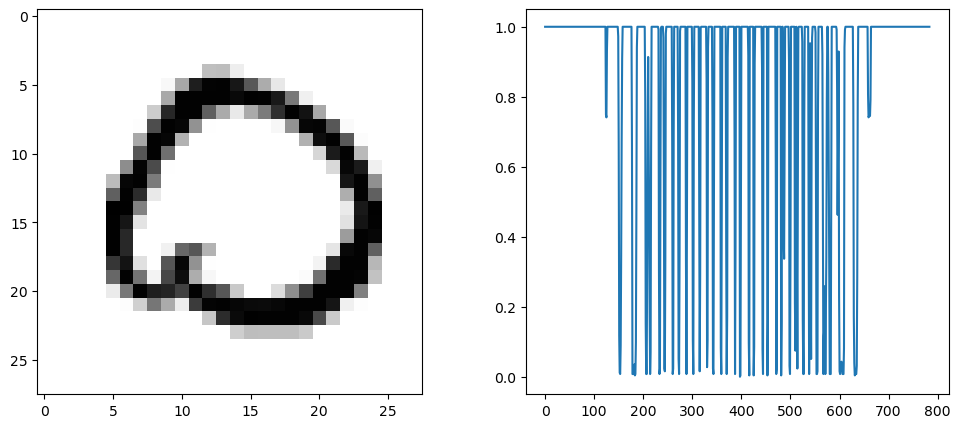

In [4]:
digit = digits[0][100]
print(digit.shape)
digit_flat = digit.flatten()
print(digit_flat.shape)

fig = plt.figure(figsize=(12, 5))
plt.subplot(121)
plt.imshow(digit, cmap='gray')
plt.subplot(122)
plt.plot(digit_flat)

The original digit image is $28 \times 28$ pixels, so when we flatten it, we get a 784 dimensional vector.  It's a little strange to look at, but we can kind of see the pattern.  Noting that pure black is 0 and pure white is 1, the top few rows are all white pixels, so we see it stays at 1 for a while, then it jumps down on each line when it passes through the 0 slice.  The animation below shows the flattening process in more detail

<img src = "FlatteningDigit.gif">


Now that we have a way to turn a digit into a vector, we can set up our data matrix <b>x</b>.  We'll also keep track of the actual labels of the digits in a parallel array <b>y</b>, though we won't actually use those labels in what we're going to do next

In [5]:
X = []
y = []
for i in range(len(digits)):
    for digit in digits[i]:
        X.append(digit.flatten())
        y.append(i)
X = np.array(X)
y = np.array(y)
print(X.shape)

(60000, 784)


Let's compute PCA on the data matrix to find the directions of greatest variance.  First, we compute the mean of all of the data points, which corresponds to computing the mean over all rows

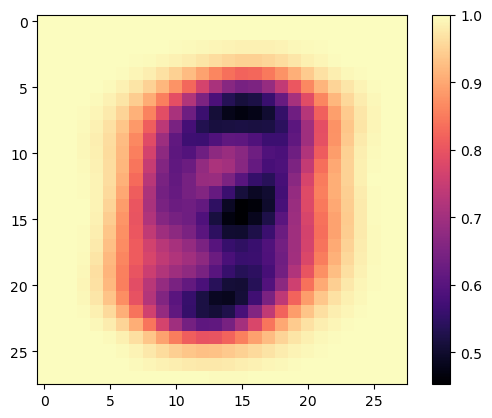

In [8]:
## TODO: Fill this in
mu = np.mean(X, axis=0) # Mean of each pixel
plt.imshow(np.reshape(mu, (28, 28)), cmap='magma')
plt.colorbar()

Let's have a look at the mean.  We have to turn it back from a flattened vector into an image by using numpy's <code><a href = "https://numpy.org/doc/stable/reference/generated/numpy.reshape.html">reshape</a></code> method

In [ ]:
## TODO: Fill this in

Now we'll subtract off the mean from each row and compute the directions of maximum variance in what remains

(784, 784)


Text(0, 0.5, 'Explained Variance Ratio')

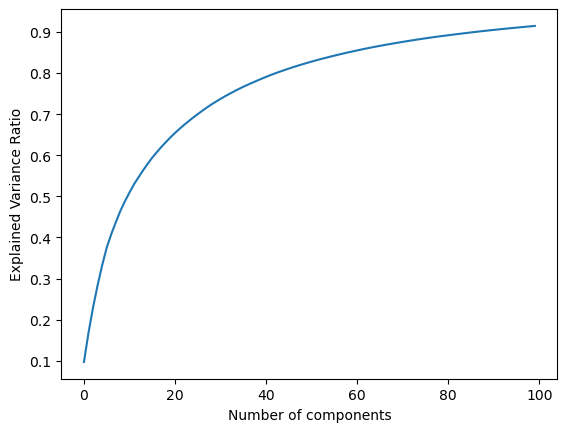

In [16]:
## TODO: Fill this in
Y = X - mu
A = (Y.T).dot(Y)
print(A.shape)
w, v = np.linalg.eigh(A)
w = w[::-1]
v = v[:, ::-1]
plt.plot(np.cumsum(w[0:100])/np.sum(w))
plt.xlabel("Number of components")
plt.ylabel("Explained Variance Ratio")

To get an idea of how much variance each direction explains, we can create a <a href = "https://en.wikipedia.org/wiki/Scree_plot">scree plot</a>, which is simply plotting the variance of each component.  When we do this, we see that the variance is captured well by many fewer than 784 dimensions

In [ ]:
## TODO: Fill this in

Let's look at a cumulative sum of the ratio to the total variance to see how many components it takes us to explain 90% of the variance.  We find that this takes about 86 dimensions

86


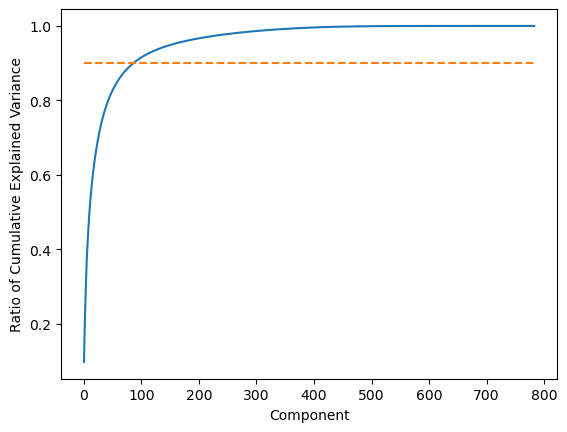

In [17]:
wcumu = np.cumsum(w)/np.sum(w)
plt.plot(wcumu)
plt.plot([0, wcumu.size], [0.9, 0.9], linestyle='--')
plt.xlabel("Component")
plt.ylabel("Ratio of Cumulative Explained Variance")
print(np.argmin(np.abs(wcumu-0.9)))

Let's pull out the first 10 directions of greatest variance and plot them.  Overall, the first 10 components account for about 50% of the variance in the dataset, and the first 20 components account for about 64% of the variance in the dataset (note the diminishing returns)

In [ ]:
print(wcumu[1])
print(wcumu[9])
print(wcumu[19])

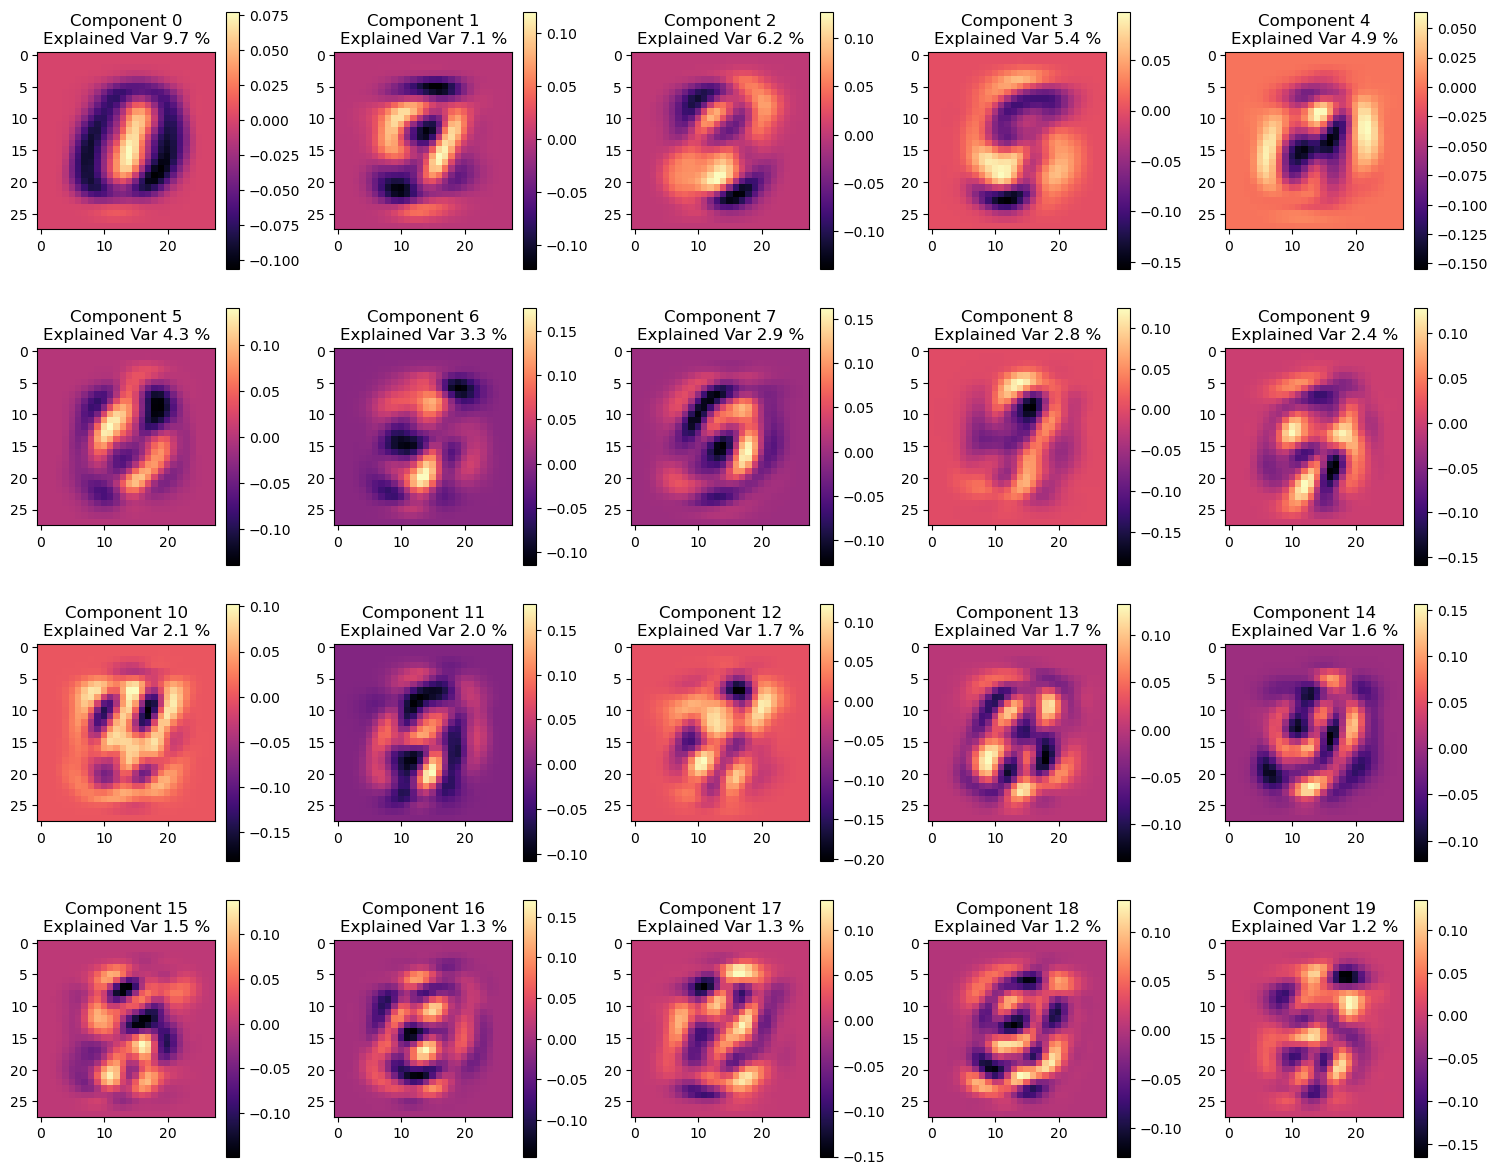

In [18]:
N = 20
plt.figure(figsize=(5*3, 4*3))
for i in range(N):
    img = np.reshape(v[:, i], (28, 28))
    plt.subplot(4, 5, i+1)
    plt.imshow(img, cmap='magma')
    plt.colorbar()
    var = w[i]/np.sum(w)
    plt.title("Component {}\nExplained Var {:.1f} %".format(i, var*100))
plt.tight_layout()

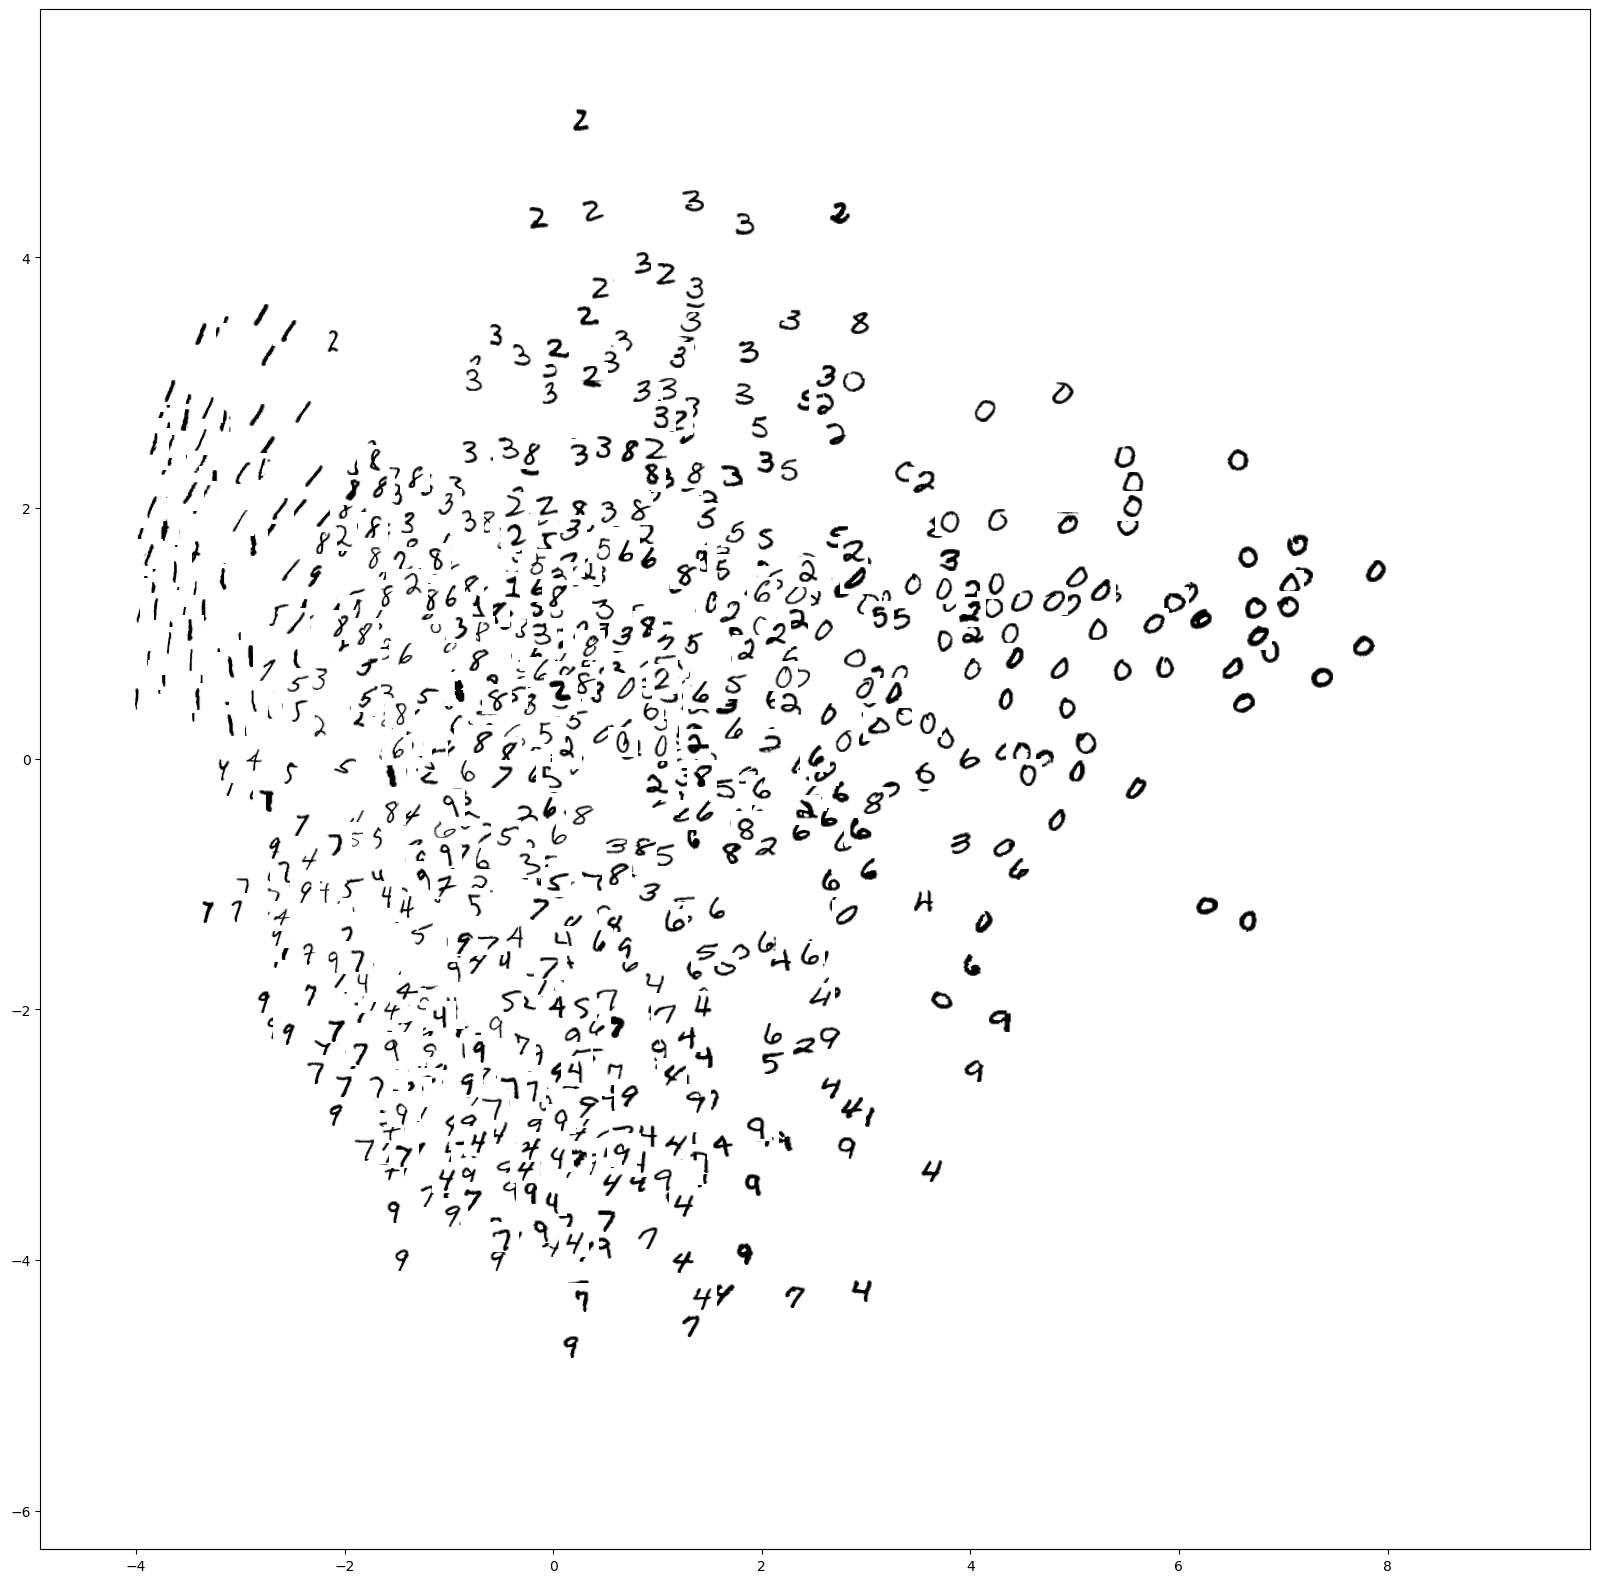

In [20]:
proj = (X - mu).dot(v[:, 0:N])
idxs = np.random.permutation(X.shape[0])[0:1000]

plt.figure(figsize=(20, 20))
ax = plt.gca()
for i in idxs:
    patch = np.reshape(X[i, :], (res, res))
    x, y = proj[i, 0:2]
    im = OffsetImage(patch, zoom=0.75, cmap = 'gray')
    ab = AnnotationBbox(im, (x, y), xycoords='data', frameon=False)
    ax.add_artist(ab)
ax.update_datalim(proj[:, 0:2])
ax.autoscale()


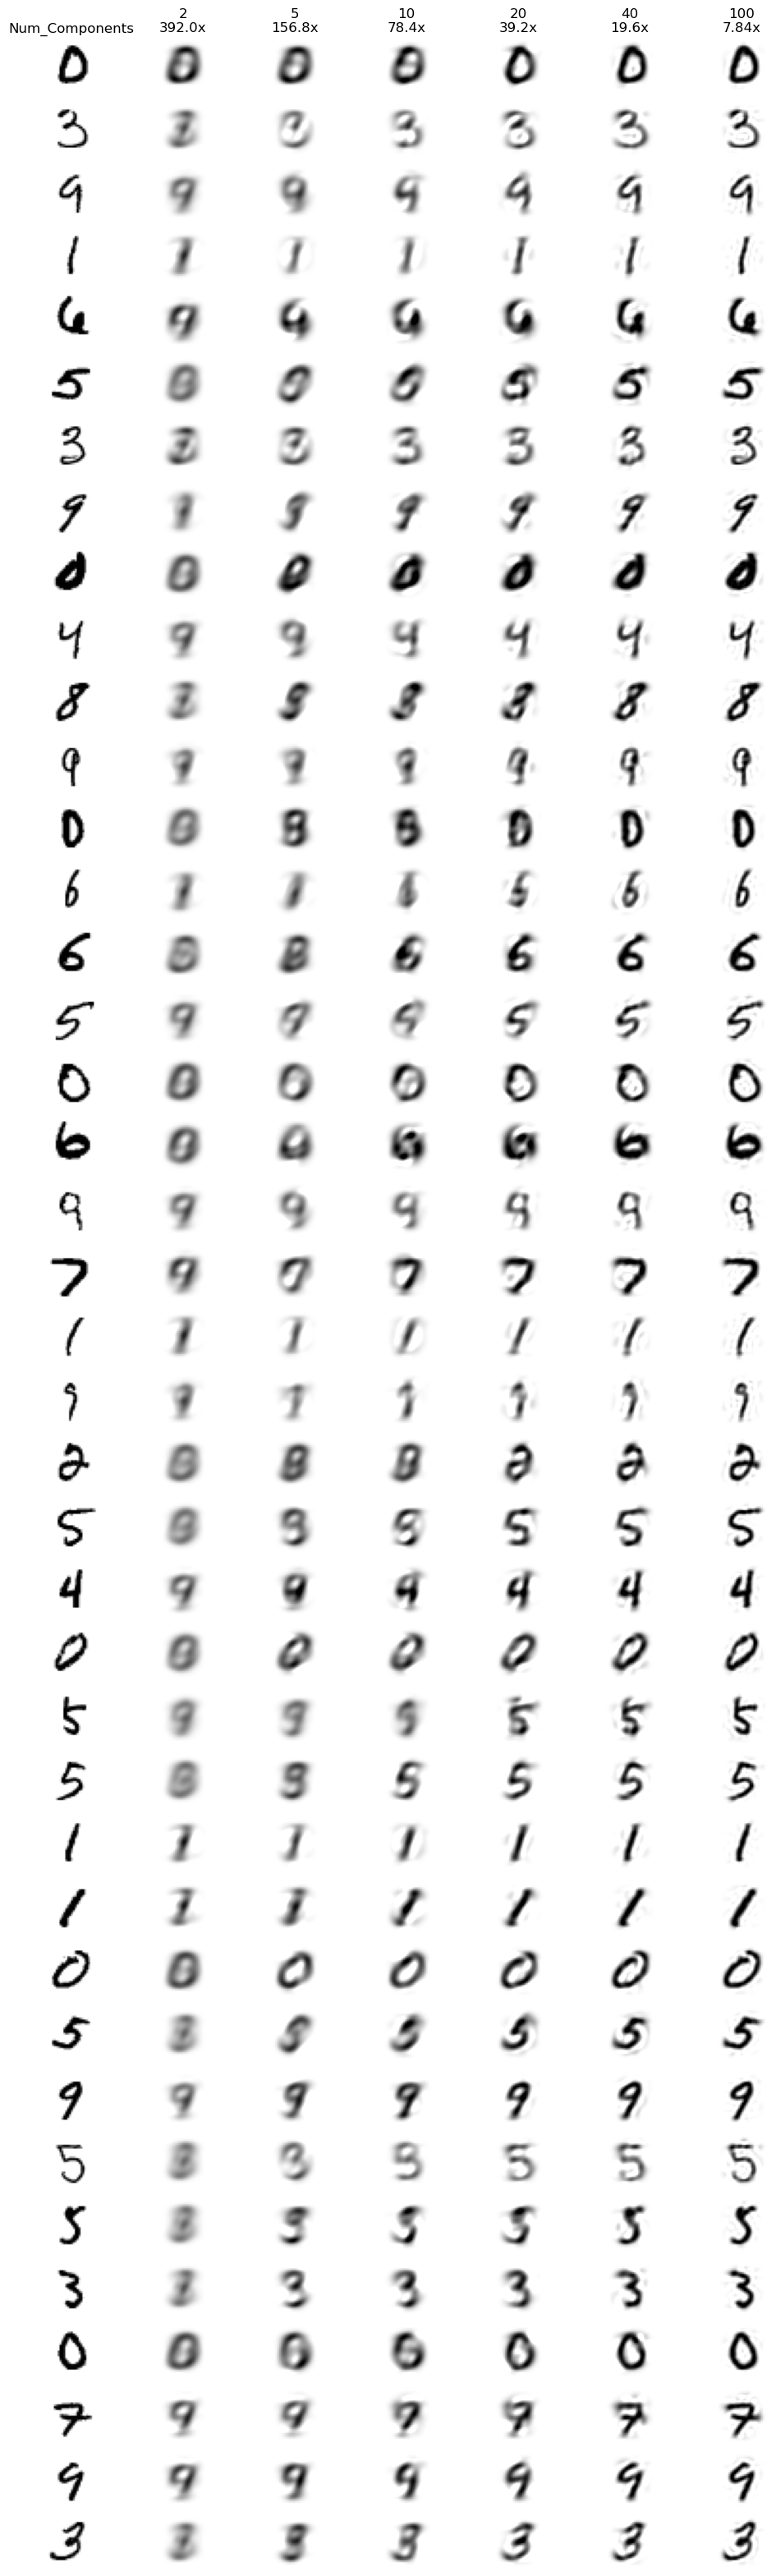

In [21]:
n_examples = 40

plt.figure(figsize=(12, n_examples))

all_ncomponents = [2, 5, 10, 20, 40, 100]
n_cols = len(all_ncomponents)+1

# Plot the original digits
np.random.seed(0)
idxs = np.random.permutation(X.shape[0])[0:n_examples]
for i, idx in enumerate(idxs):
    plt.subplot(n_examples, n_cols, 1+n_cols*i)
    plt.imshow(np.reshape(X[idx, :], (res, res)), cmap='gray')
    plt.clim([0, 1])
    plt.axis("off")
    if i == 0:
        plt.title("Num_Components")


for col, n_components in enumerate(all_ncomponents):
    for i, idx in enumerate(idxs):
        x = X[idx, :] - mu
        proj = np.array(mu)
        for k in range(n_components):
            proj += v[:, k]*np.sum(v[:, k]*x)
        plt.subplot(n_examples, n_cols, n_cols*i + col + 2)
        plt.imshow(np.reshape(proj, (res, res)), cmap='gray')
        plt.axis("off")
        plt.clim([0, 1])
        if i == 0:
            plt.title("{}\n{}x".format(n_components, x.size/n_components))

In [22]:
print(A.shape)

(784, 784)
